In [87]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [88]:
from matplotlib.backends.backend_pdf import PdfPages

In [54]:
%matplotlib inline

In [55]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [56]:
def readFile(filename):
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.",filename)
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [57]:
NC_HPI = readFile("NC_HousePriceIndex.csv")

File read into dataframe. NC_HousePriceIndex.csv
(39, 1)


In [58]:
def renameColumn(df):
    df.rename(columns={'DC_House Price Index': 'DC_HousePriceIndex'}, inplace=True)
    df.rename(columns={'MD_House Price Index': 'MD_HousePriceIndex'}, inplace=True)
    df.rename(columns={'SC_House Price Index': 'SC_HousePriceIndex'}, inplace=True)
    df.rename(columns={'NC_House Price Index': 'NC_HousePriceIndex'}, inplace=True)
    df.rename(columns={'VA_House Price Index': 'VA_HousePriceIndex'}, inplace=True)
    df.rename(columns={'WV_House Price Index': 'WV_HousePriceIndex'}, inplace=True)
    df.rename(columns={'DC_Total Personal Income': 'DC_TotalPersonalIncome'}, inplace=True)
    df.rename(columns={'MD_Total Personal Income': 'MD_TotalPersonalIncome'}, inplace=True)
    df.rename(columns={'NC_Total Personal Income': 'NC_TotalPersonalIncome'}, inplace=True)
    df.rename(columns={'SC_Total Personal Income': 'SC_TotalPersonalIncome'}, inplace=True)
    df.rename(columns={'VA_Total Personal Income': 'VA_TotalPersonalIncome'}, inplace=True)
    df.rename(columns={'WV_Total Personal Income': 'WV_TotalPersonalIncome'}, inplace=True)
    df.rename(columns={'DC_Gross State Product (Real)': 'DC_GDP'}, inplace=True)
    df.rename(columns={'MD_Gross State Product (Real)': 'MD_GDP'}, inplace=True)
    df.rename(columns={'NC_Gross State Product (Real)': 'NC_GDP'}, inplace=True)
    df.rename(columns={'SC_Gross State Product (Real)': 'SC_GDP'}, inplace=True)
    df.rename(columns={'VA_Gross State Product (Real)': 'VA_GDP'}, inplace=True)
    df.rename(columns={'WV_Gross State Product (Real)': 'WV_GDP'}, inplace=True)
    df.rename(columns={'DC_Unemployment Rate (Household Survey)': 'DC_UnemploymentRate'}, inplace=True)
    df.rename(columns={'MD_Unemployment Rate (Household Survey)': 'MD_UnemploymentRate'}, inplace=True)
    df.rename(columns={'NC_Unemployment Rate (Household Survey)': 'NC_UnemploymentRate'}, inplace=True)
    df.rename(columns={'SC_Unemployment Rate (Household Survey)': 'SC_UnemploymentRate'}, inplace=True)
    df.rename(columns={'VA_Unemployment Rate (Household Survey)': 'VA_UnemploymentRate'}, inplace=True)
    df.rename(columns={'WV_Unemployment Rate (Household Survey)': 'WV_UnemploymentRate'}, inplace=True)
    return df
    
    

In [60]:
renameColumn(NC_HPI)

In [8]:
NC_HPI.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [9]:
NC_HPI.head()

,NC_HousePriceIndex
1977-01-01,76.3400
1978-01-01,85.0225
1979-01-01,93.8025
1980-01-01,100.4875
1981-01-01,105.4125


In [10]:
NC_HPI.NC_HousePriceIndex.describe()

count     39.000000
mean     209.867308
std       82.828992
min       76.340000
25%      143.626250
50%      200.307500
75%      296.063750
max      336.182500
Name: NC_HousePriceIndex, dtype: float64

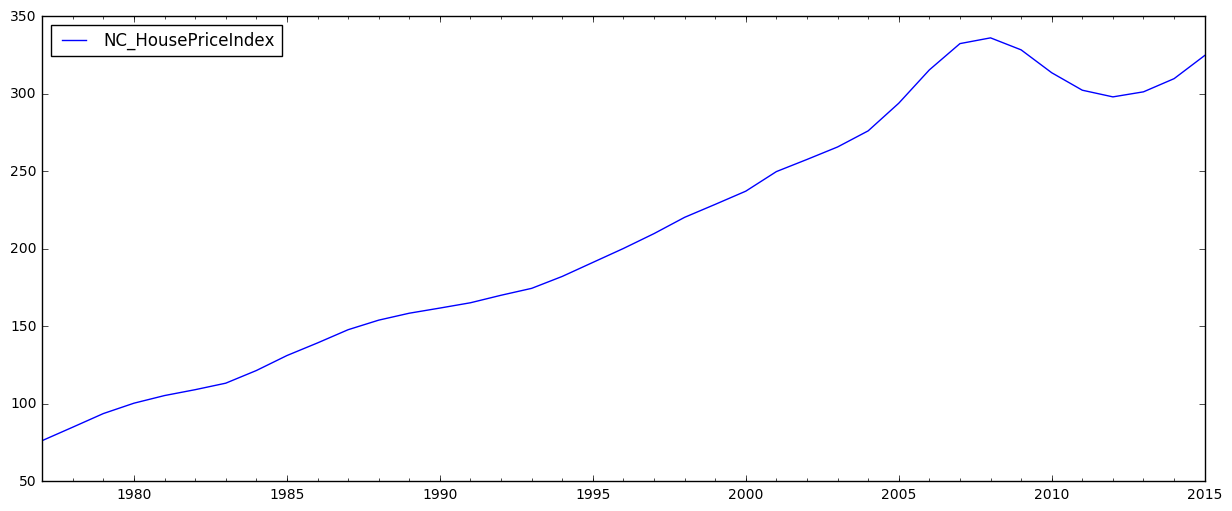

In [62]:
NC_HPI.plot(figsize=(15,6))
plt.show()
plt.savefig('books_read.png')

There is an overall increasing trend in the data.We can see dip after 2007 for crisis period and then there is again increase in the trend.

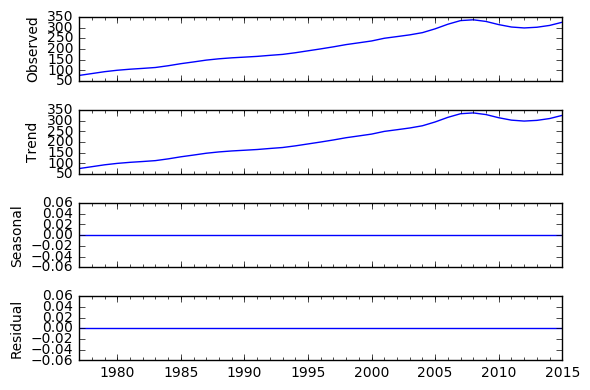

In [63]:
#Decomposing into  trend, seasonal and residual using additive model.
decomposition = sm.tsa.seasonal_decompose(NC_HPI, model='additive')
fig = decomposition.plot()
plt.show()
fig.savefig('NC_Seasonal_Decompose.png', dpi=150)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not. First, check the mean and variance. Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [76]:
#we can split our dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('Mean and Variance','mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [77]:
meanVarianceCheck(NC_HPI)

('Mean and Variance',
 'mean1=135.878816, mean2=280.156375',
 'variance1=1155.850569, variance2=1796.026549')

In [78]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    dfoutput.to_csv("Test_Statistics.csv")    
    print(dfoutput)

In [79]:
test_stationarity(NC_HPI.NC_HousePriceIndex)

Results of Dickey-Fuller Test:
Test Statistic                 -0.479554
p-value                         0.895945
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [15]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

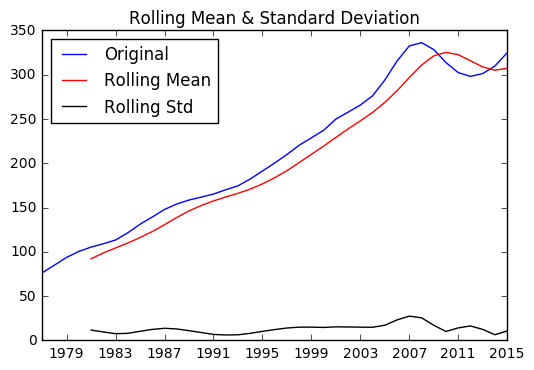

Results of Dickey-Fuller Test:
Test Statistic                 -0.479554
p-value                         0.895945
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [16]:
test_stationarity(NC_HPI.NC_HousePriceIndex)

# Estimating & Eliminating Trend

In [17]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

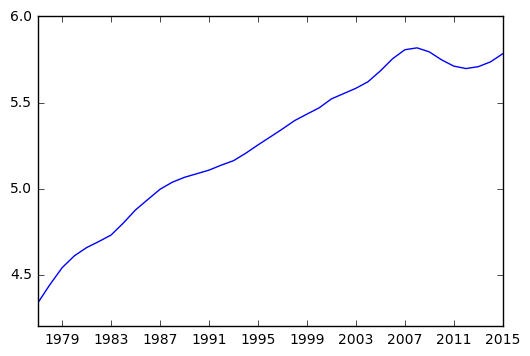

In [18]:
ts_log = logTransform(NC_HPI)

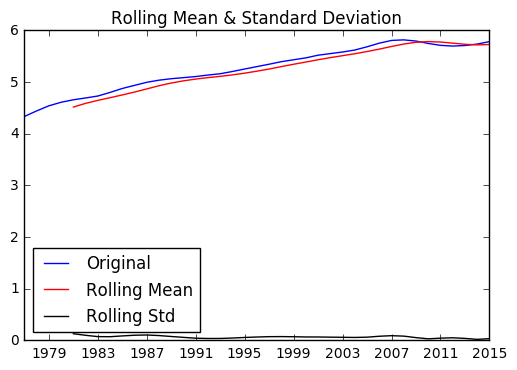

Results of Dickey-Fuller Test:
Test Statistic                 -2.358283
p-value                         0.153858
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [19]:
test_stationarity(ts_log.NC_HousePriceIndex)

In [20]:
#Differencing - taking the differece with a particular time lag
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

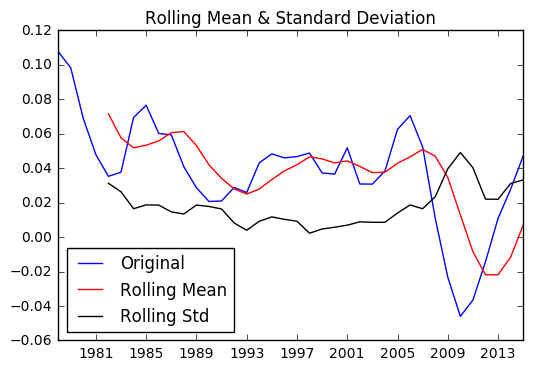

Results of Dickey-Fuller Test:
Test Statistic                 -3.968591
p-value                         0.001584
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [21]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.NC_HousePriceIndex)

In [22]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

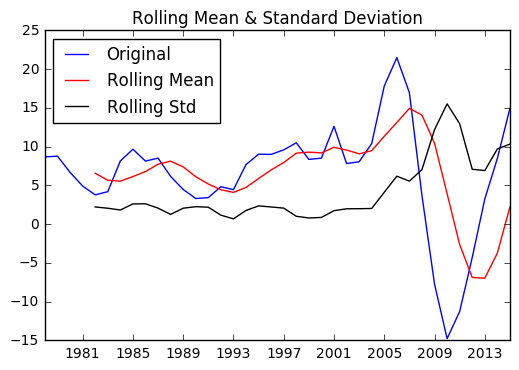

Results of Dickey-Fuller Test:
Test Statistic                 -4.992394
p-value                         0.000023
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [23]:
ts_first_diff = firstDifference(NC_HPI)
test_stationarity(ts_first_diff.NC_HousePriceIndex)

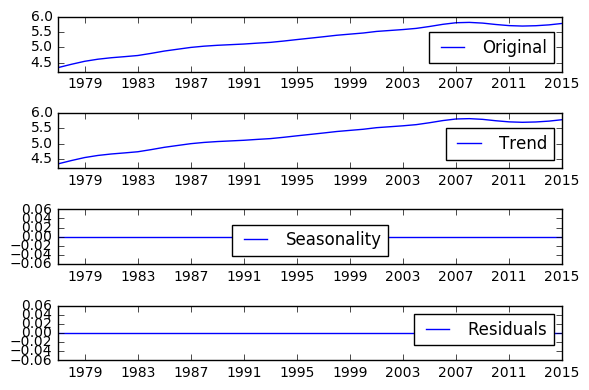

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

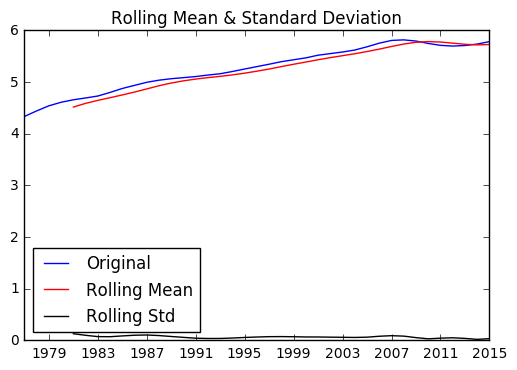

Results of Dickey-Fuller Test:
Test Statistic                 -2.358283
p-value                         0.153858
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (5%)            -2.945951
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
dtype: float64


In [25]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.NC_HousePriceIndex)

In [26]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

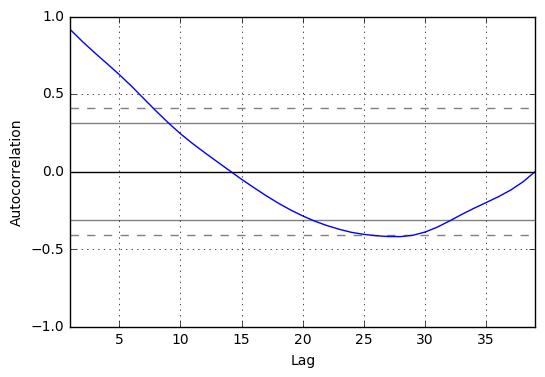

In [27]:
autocorrelation_plot(ts_log)
plt.show()

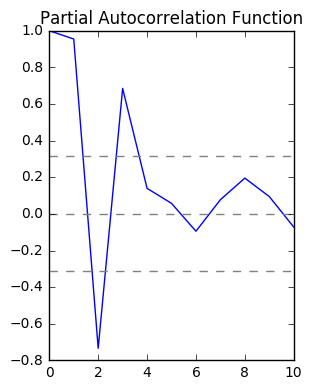

In [28]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [83]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [84]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [95]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                       4.844204
ar.L1.NC_HousePriceIndex    1.951078
ar.L2.NC_HousePriceIndex   -0.953471
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     NC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 0)   Log Likelihood                  97.773
Method:                       css-mle   S.D. of innovations              0.017
Date:                Thu, 27 Apr 2017   AIC                           -187.545
Time:                        16:16:11   BIC                           -180.891
Sample:                    01-01-1977   HQIC                          -185.158
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        4.8442

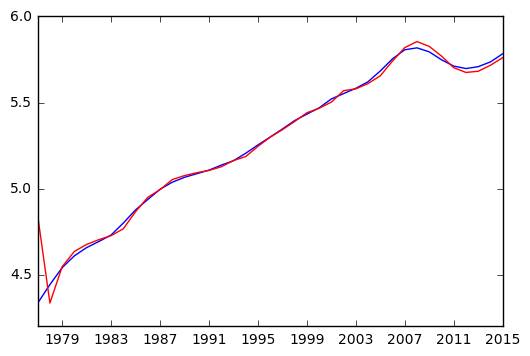

In [96]:
model_AR = AR_Model(ts_log)

In [77]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0, 0, 1))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 1))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                       5.254972
ma.L1.NC_HousePriceIndex    0.999976
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     NC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(0, 1)   Log Likelihood                   0.951
Method:                       css-mle   S.D. of innovations              0.225
Date:                Wed, 26 Apr 2017   AIC                              4.097
Time:                        22:39:37   BIC                              9.088
Sample:                    01-01-1977   HQIC                             5.888
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.2550      0.071     73.780      0.000    

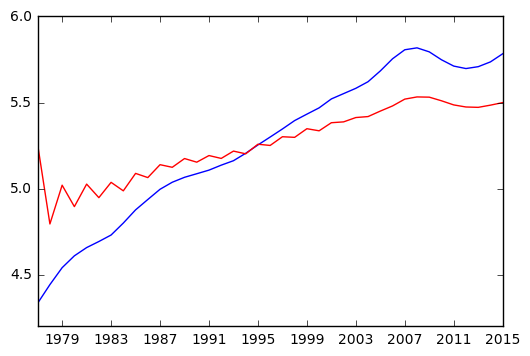

In [78]:
model_MA = MA_Model(ts_log)

In [91]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(2, 0, 1))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 1))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts_log)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 2
Coefficients: const                       4.966073
ar.L1.NC_HousePriceIndex    1.916743
ar.L2.NC_HousePriceIndex   -0.919671
ma.L1.NC_HousePriceIndex    0.563933
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     NC_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 1)   Log Likelihood                 104.420
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 27 Apr 2017   AIC                           -198.840
Time:                        15:48:55   BIC                           -190.522
Sample:                    01-01-1977   HQIC                          -195.856
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

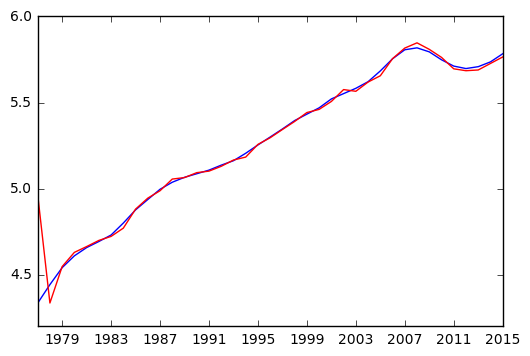

In [92]:
model_Combined = Combined_Model(ts_log)

In [64]:
aic_metric

,AIC,Modelname
0,-200.528162,"ARIMA(ts, order=(3, 0, 0))"
0,4.097298,"ARIMA(ts, order=(0, 0, 1))"
0,-199.626263,"ARIMA(ts, order=(3, 0, 1))"


In [65]:
aic_dict

{'ARIMA(ts, order=(0, 0, 1))': 4.097298093287151,
 'ARIMA(ts, order=(3, 0, 0))': -200.52816212815176,
 'ARIMA(ts, order=(3, 0, 1))': -199.62626288358499}

In [67]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(3, 0, 0))


In [80]:
min(aic_dict.items(),key=operator.itemgetter(1))[0]

'ARIMA(ts, order=(2, 0, 0))'

In [93]:
#Forecast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output 

In [94]:
output_forecast = forecast(model_Combined,5)

[ 341.95288727  357.60566949  371.63764233  383.95644265  394.50708126]


In [51]:
#AR model
#model = ARIMA(ts_log, order=(3, 1, 0))
#results_AR = model.fit(disp=0)  
#print(results_AR.summary())
#print('Lag: %s' % results_AR.k_ar)
#print('Coefficients: %s' % results_AR.params)
#plt.plot(ts_log_diff)
#plt.plot(results_AR.fittedvalues, color='red')
#print(results_AR.aic)


#MA model
#model = ARIMA(ts_log, order=(0, 1, 1))  
#results_MA = model.fit(disp=-1)  
#print('Lag: %s' % results_MA.k_ar)
#print('Coefficients: %s' % results_MA.params)
#print(results_MA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_MA.fittedvalues, color='red')


#Combined model
#model = ARIMA(ts_log, order=(3, 1, 1))  
#results_ARIMA = model.fit(disp=-1) 
#print('Lag: %s' % results_ARIMA.k_ar)
#print('Coefficients: %s' % results_ARIMA.params)
#print(results_ARIMA.summary())
#plt.plot(ts_log_diff)
#plt.plot(results_ARIMA.fittedvalues, color='red')